<a href="https://colab.research.google.com/github/ClaFlorez/Machine_Learning_Simplifie/blob/main/8_3_DBSCAN_clustering_exhaustif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DBSCAN: Détection de fraude dans les transactions bancaires
Dataset de transactions créé:
  Nombre total: 800
  Montant moyen: 318.62€
  Heure moyenne: 10.4h

Distribution des vraies catégories:
  Fraudes: 50 transactions
  Groupe 0: 300 transactions
  Groupe 1: 200 transactions
  Groupe 2: 150 transactions
  Groupe 3: 100 transactions

Optimisation des paramètres DBSCAN:
Estimation automatique d'eps: 0.707

Test de différents paramètres:
Eps      MinSamples   N_Clusters   N_Noise    Silhouette
------------------------------------------------------------
0.354    3            11           16         0.707
0.354    4            8            25         0.709
0.354    5            3            45         0.718
0.354    6            2            50         0.716
0.707    3            4            0          0.665
0.707    4            4            2          0.665
0.707    5            5            2          0.644
0.707    6            6            6          0.529
1.061    3            2

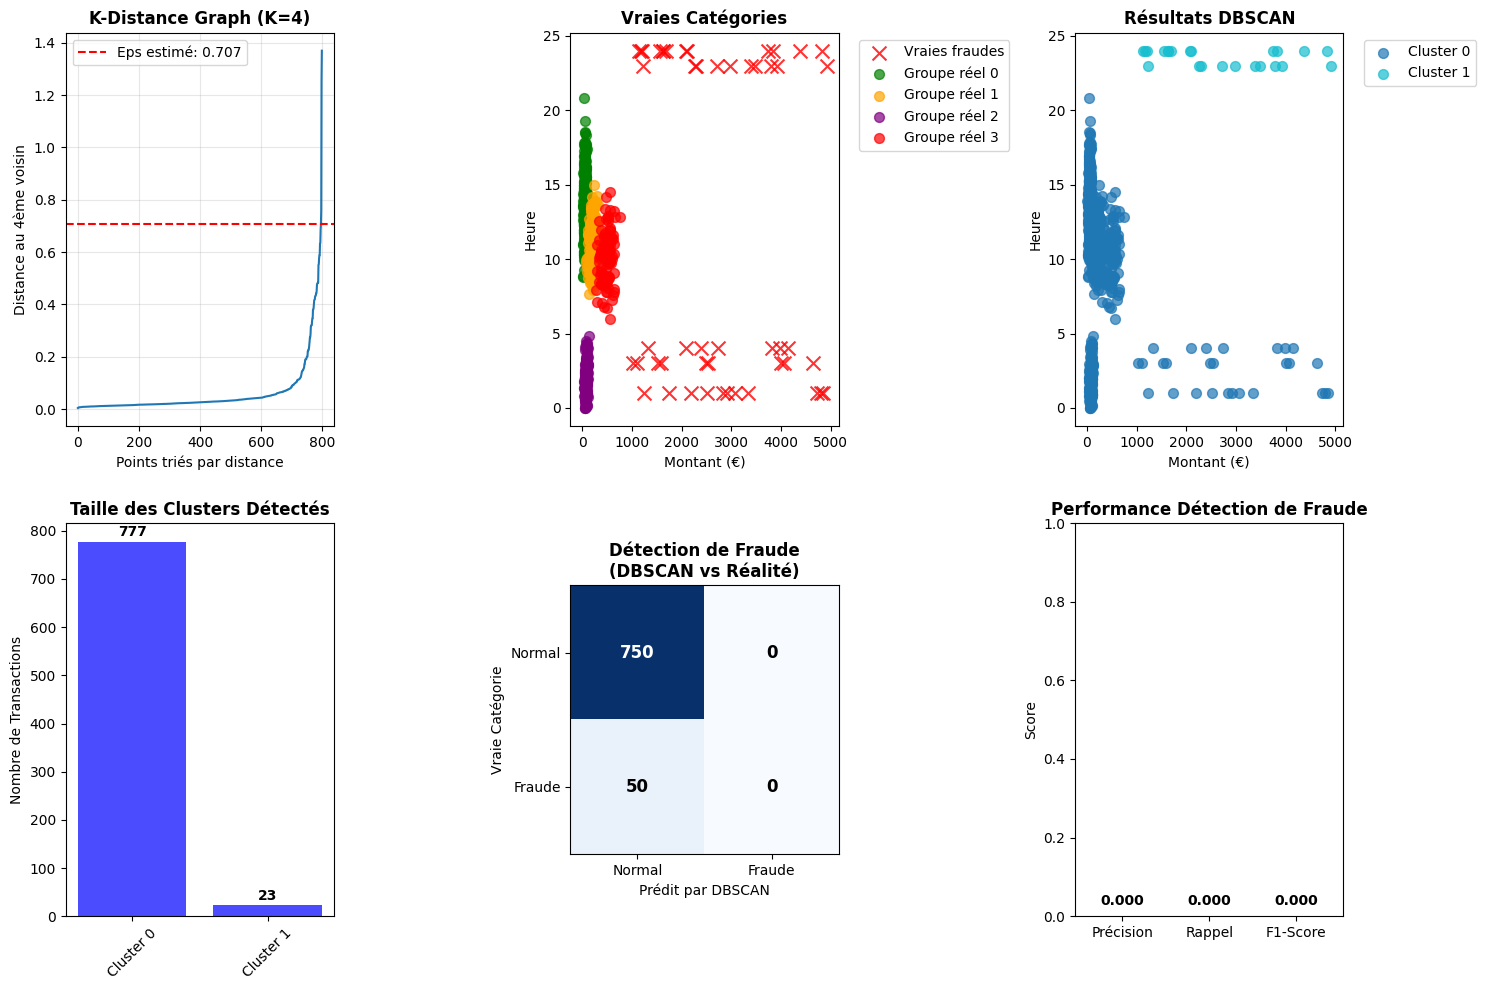


Analyse détaillée de la détection de fraude:
Performance de détection:
  Vraies fraudes: 50
  Fraudes détectées: 0
  Vraies fraudes trouvées: 0 (0.0%)
  Fausses alertes: 0
  Fraudes ratées: 50

Métriques:
  Précision: 0.000 (0.0%)
  Rappel: 0.000 (0.0%)
  F1-Score: 0.000

Analyse des clusters détectés par DBSCAN:

Cluster 0 (777 transactions):
  Montant moyen: 248.28€
  Heure moyenne: 10.0h
  Écart-type montant: 567.13€
  Écart-type heure: 4.84h
  → Type probable: Achats week-end

Cluster 1 (23 transactions):
  Montant moyen: 2694.95€
  Heure moyenne: 23.6h
  Écart-type montant: 1231.72€
  Écart-type heure: 0.51h
  → Type probable: Transactions nocturnes

Comparaison avec autres méthodes de clustering:
Accord avec vraies catégories (ARI):
  K-Means: 0.324
  Hiérarchique: 0.320
  DBSCAN: 0.000

Capacité de détection d'anomalies:
DBSCAN:
  Précision fraude: 0.000
  Rappel fraude: 0.000
  → Spécialement conçu pour détecter les outliers

K-Means et Hiérarchique:
  → Ne détectent PAS les o

In [1]:
#DBSCAN clustering exhaustif
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Créer un dataset complexe pour montrer la puissance de DBSCAN
print("DBSCAN: Détection de fraude dans les transactions bancaires")
print("=" * 70)

np.random.seed(42)

# Simuler des transactions bancaires avec groupes naturels et anomalies
n_transactions = 1000

# Groupe 1: Transactions quotidiennes normales
normal_daily = np.random.multivariate_normal(
    [50, 14],  # 50€ vers 14h
    [[200, 10], [10, 4]],
    300
)

# Groupe 2: Gros achats week-end
weekend_shopping = np.random.multivariate_normal(
    [200, 11],  # 200€ vers 11h
    [[2000, 20], [20, 2]],
    200
)

# Groupe 3: Transactions nocturnes (distributeurs)
night_atm = np.random.multivariate_normal(
    [80, 2],  # 80€ vers 2h du matin
    [[400, 5], [5, 1]],
    150
)

# Groupe 4: Transactions business
business_trans = np.random.multivariate_normal(
    [500, 10],  # 500€ vers 10h
    [[10000, 50], [50, 3]],
    100
)

# Anomalies : transactions frauduleuses
fraud_trans = []
for _ in range(50):  # 50 transactions suspectes
    # Montants très élevés à heures bizarres
    montant = np.random.uniform(1000, 5000)
    heure = np.random.choice([3, 4, 23, 24, 1])  # Heures suspectes
    fraud_trans.append([montant, heure])

fraud_trans = np.array(fraud_trans)

# Combiner toutes les données
X_all = np.vstack([normal_daily, weekend_shopping, night_atm, business_trans, fraud_trans])

# Créer les vraies étiquettes pour validation
true_labels = (
    [0] * 300 +  # Transactions normales
    [1] * 200 +  # Week-end shopping
    [2] * 150 +  # Nocturnes
    [3] * 100 +  # Business
    [-1] * 50    # Fraudes (outliers)
)

# Créer le DataFrame
df_transactions = pd.DataFrame(X_all, columns=['montant', 'heure'])
df_transactions['vraie_categorie'] = true_labels

# Nettoyer les données
df_transactions['montant'] = np.clip(df_transactions['montant'], 1, 10000)
df_transactions['heure'] = np.clip(df_transactions['heure'], 0, 24)

print(f"Dataset de transactions créé:")
print(f"  Nombre total: {len(df_transactions):,}")
print(f"  Montant moyen: {df_transactions['montant'].mean():.2f}€")
print(f"  Heure moyenne: {df_transactions['heure'].mean():.1f}h")

# Distribution des vraies catégories
print(f"\nDistribution des vraies catégories:")
for cat in sorted(df_transactions['vraie_categorie'].unique()):
    count = (df_transactions['vraie_categorie'] == cat).sum()
    if cat == -1:
        print(f"  Fraudes: {count} transactions")
    else:
        print(f"  Groupe {cat}: {count} transactions")

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transactions[['montant', 'heure']])

print(f"\nOptimisation des paramètres DBSCAN:")
print("=" * 50)

# DBSCAN a 2 paramètres principaux:
# - eps: rayon de voisinage
# - min_samples: nombre minimum de voisins

# Méthode pour estimer eps : k-distance graph
from sklearn.neighbors import NearestNeighbors

# Calculer les distances aux k plus proches voisins
k = 4  # Règle empirique: dimensionalité + 1
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Prendre la distance au k-ième voisin et trier
k_distances = distances[:, k-1]
k_distances_sorted = np.sort(k_distances)

# Visualiser le k-distance graph
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(k_distances_sorted)
plt.title('K-Distance Graph (K=4)', fontweight='bold')
plt.xlabel('Points triés par distance')
plt.ylabel(f'Distance au {k}ème voisin')
plt.grid(True, alpha=0.3)

# Détecter le "coude" pour estimer eps
# Méthode simple: chercher la plus grande accélération
differences = np.diff(k_distances_sorted)
second_diff = np.diff(differences)
knee_point = np.argmax(second_diff)
eps_estimate = k_distances_sorted[knee_point]

plt.axhline(y=eps_estimate, color='red', linestyle='--',
           label=f'Eps estimé: {eps_estimate:.3f}')
plt.legend()

print(f"Estimation automatique d'eps: {eps_estimate:.3f}")

# Tester différentes combinaisons de paramètres
eps_values = [eps_estimate * 0.5, eps_estimate, eps_estimate * 1.5, eps_estimate * 2]
min_samples_values = [3, 4, 5, 6]

print(f"\nTest de différents paramètres:")
print("=" * 60)
print(f"{'Eps':<8} {'MinSamples':<12} {'N_Clusters':<12} {'N_Noise':<10} {'Silhouette'}")
print("-" * 60)

best_params = None
best_silhouette = -1
dbscan_results = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        # Appliquer DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_scaled)

        # Analyser les résultats
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = list(clusters).count(-1)

        # Calculer silhouette score (seulement si au moins 2 clusters)
        if n_clusters > 1:
            # Exclure le bruit pour le calcul du silhouette
            mask_no_noise = clusters != -1
            if mask_no_noise.sum() > 1:
                sil_score = silhouette_score(X_scaled[mask_no_noise], clusters[mask_no_noise])
            else:
                sil_score = -1
        else:
            sil_score = -1

        dbscan_results[(eps, min_samples)] = {
            'clusters': clusters,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score
        }

        print(f"{eps:<8.3f} {min_samples:<12} {n_clusters:<12} {n_noise:<10} {sil_score:<.3f}")

        # Garder les meilleurs paramètres
        if sil_score > best_silhouette and n_clusters > 0:
            best_silhouette = sil_score
            best_params = (eps, min_samples)

print(f"\nMeilleurs paramètres trouvés:")
print(f"  Eps: {best_params[0]:.3f}")
print(f"  Min_samples: {best_params[1]}")
print(f"  Silhouette score: {best_silhouette:.3f}")

# Appliquer DBSCAN avec les meilleurs paramètres
dbscan_final = DBSCAN(eps=best_params[0], min_samples=best_params[1])
clusters_final = dbscan_final.fit_predict(X_scaled)
df_transactions['cluster_dbscan'] = clusters_final

# Analyser les résultats finaux
n_clusters_final = len(set(clusters_final)) - (1 if -1 in clusters_final else 0)
n_noise_final = list(clusters_final).count(-1)

print(f"\nRésultats finaux DBSCAN:")
print("=" * 40)
print(f"Clusters détectés: {n_clusters_final}")
print(f"Points de bruit: {n_noise_final}")
print(f"Taux de bruit: {n_noise_final/len(df_transactions)*100:.1f}%")

# Visualisations comparatives
plt.subplot(2, 3, 2)
# Données originales
colors_true = ['blue', 'green', 'orange', 'purple', 'red']
for i, label in enumerate(sorted(df_transactions['vraie_categorie'].unique())):
    mask = df_transactions['vraie_categorie'] == label
    if label == -1:
        plt.scatter(df_transactions[mask]['montant'], df_transactions[mask]['heure'],
                   c='red', marker='x', s=100, alpha=0.8, label='Vraies fraudes')
    else:
        plt.scatter(df_transactions[mask]['montant'], df_transactions[mask]['heure'],
                   c=colors_true[i], alpha=0.7, s=50, label=f'Groupe réel {label}')

plt.title('Vraies Catégories', fontweight='bold')
plt.xlabel('Montant (€)')
plt.ylabel('Heure')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Résultats DBSCAN
plt.subplot(2, 3, 3)
unique_clusters = sorted(set(clusters_final))
colors_dbscan = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = clusters_final == cluster_id
    if cluster_id == -1:
        plt.scatter(df_transactions[mask]['montant'], df_transactions[mask]['heure'],
                   c='red', marker='x', s=100, alpha=0.8, label='Bruit détecté')
    else:
        plt.scatter(df_transactions[mask]['montant'], df_transactions[mask]['heure'],
                   c=[colors_dbscan[i]], alpha=0.7, s=50, label=f'Cluster {cluster_id}')

plt.title('Résultats DBSCAN', fontweight='bold')
plt.xlabel('Montant (€)')
plt.ylabel('Heure')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Analyse des clusters trouvés
plt.subplot(2, 3, 4)
cluster_sizes = []
cluster_labels = []

for cluster_id in sorted(set(clusters_final)):
    size = (clusters_final == cluster_id).sum()
    cluster_sizes.append(size)
    if cluster_id == -1:
        cluster_labels.append('Bruit')
    else:
        cluster_labels.append(f'Cluster {cluster_id}')

bars = plt.bar(cluster_labels, cluster_sizes, alpha=0.7,
               color=['red' if 'Bruit' in label else 'blue' for label in cluster_labels])
plt.title('Taille des Clusters Détectés', fontweight='bold')
plt.ylabel('Nombre de Transactions')
plt.xticks(rotation=45)

# Ajouter les valeurs sur les barres
for bar, size in zip(bars, cluster_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
             str(size), ha='center', va='bottom', fontweight='bold')

# Matrice de confusion pour évaluer la détection de fraude
plt.subplot(2, 3, 5)
vraies_fraudes = (df_transactions['vraie_categorie'] == -1)
fraudes_detectees = (clusters_final == -1)

# Calculer la matrice de confusion
tp = (vraies_fraudes & fraudes_detectees).sum()  # Vraies fraudes détectées
fp = (~vraies_fraudes & fraudes_detectees).sum()  # Normales marquées comme fraudes
fn = (vraies_fraudes & ~fraudes_detectees).sum()  # Fraudes ratées
tn = (~vraies_fraudes & ~fraudes_detectees).sum()  # Normales correctement identifiées

confusion_matrix = np.array([[tn, fp], [fn, tp]])
im = plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')

plt.title('Détection de Fraude\n(DBSCAN vs Réalité)', fontweight='bold')
plt.xlabel('Prédit par DBSCAN')
plt.ylabel('Vraie Catégorie')
plt.xticks([0, 1], ['Normal', 'Fraude'])
plt.yticks([0, 1], ['Normal', 'Fraude'])

# Ajouter les valeurs dans la matrice
for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{confusion_matrix[i, j]}',
                ha="center", va="center", color="white" if confusion_matrix[i, j] > confusion_matrix.max()/2 else "black",
                fontweight='bold', fontsize=12)

# Métriques de détection
precision_fraud = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_fraud = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_fraud = 2 * (precision_fraud * recall_fraud) / (precision_fraud + recall_fraud) if (precision_fraud + recall_fraud) > 0 else 0

plt.subplot(2, 3, 6)
metrics_names = ['Précision', 'Rappel', 'F1-Score']
metrics_values = [precision_fraud, recall_fraud, f1_fraud]
colors_metrics = ['lightblue', 'lightgreen', 'lightcoral']

bars = plt.bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.8)
plt.title('Performance Détection de Fraude', fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)

# Ajouter les valeurs sur les barres
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyse détaillée des résultats
print(f"\nAnalyse détaillée de la détection de fraude:")
print("=" * 60)

print(f"Performance de détection:")
print(f"  Vraies fraudes: {(vraies_fraudes).sum()}")
print(f"  Fraudes détectées: {fraudes_detectees.sum()}")
print(f"  Vraies fraudes trouvées: {tp} ({recall_fraud:.1%})")
print(f"  Fausses alertes: {fp}")
print(f"  Fraudes ratées: {fn}")

print(f"\nMétriques:")
print(f"  Précision: {precision_fraud:.3f} ({precision_fraud:.1%})")
print(f"  Rappel: {recall_fraud:.3f} ({recall_fraud:.1%})")
print(f"  F1-Score: {f1_fraud:.3f}")

# Analyser chaque cluster détecté
print(f"\nAnalyse des clusters détectés par DBSCAN:")
print("=" * 60)

for cluster_id in sorted(set(clusters_final)):
    cluster_data = df_transactions[clusters_final == cluster_id]

    if cluster_id == -1:
        print(f"\nBRUIT/ANOMALIES ({len(cluster_data)} transactions):")
        print(f"  Montant moyen: {cluster_data['montant'].mean():.2f}€")
        print(f"  Heure moyenne: {cluster_data['heure'].mean():.1f}h")
        print(f"  Montant max: {cluster_data['montant'].max():.0f}€")
        print(f"  Montant min: {cluster_data['montant'].min():.0f}€")

        # Analyser si ce sont vraiment des fraudes
        vraies_fraudes_detectees = (cluster_data['vraie_categorie'] == -1).sum()
        print(f"  Vraies fraudes dans ce groupe: {vraies_fraudes_detectees}/{len(cluster_data)}")

    else:
        print(f"\nCluster {cluster_id} ({len(cluster_data)} transactions):")
        print(f"  Montant moyen: {cluster_data['montant'].mean():.2f}€")
        print(f"  Heure moyenne: {cluster_data['heure'].mean():.1f}h")
        print(f"  Écart-type montant: {cluster_data['montant'].std():.2f}€")
        print(f"  Écart-type heure: {cluster_data['heure'].std():.2f}h")

        # Identifier le type de transaction le plus probable
        if cluster_data['montant'].mean() < 100 and 12 <= cluster_data['heure'].mean() <= 18:
            type_probable = "Transactions quotidiennes"
        elif cluster_data['montant'].mean() > 300 and 8 <= cluster_data['heure'].mean() <= 12:
            type_probable = "Transactions business"
        elif cluster_data['heure'].mean() < 6 or cluster_data['heure'].mean() > 22:
            type_probable = "Transactions nocturnes"
        elif 100 <= cluster_data['montant'].mean() <= 300:
            type_probable = "Achats week-end"
        else:
            type_probable = "Type mixte"

        print(f"  → Type probable: {type_probable}")

# Comparer avec K-Means et Clustering Hiérarchique
print(f"\nComparaison avec autres méthodes de clustering:")
print("=" * 60)

# K-Means (forcer à 4 clusters comme les vrais groupes)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Clustering hiérarchique
from scipy.cluster.hierarchy import linkage, fcluster
Z = linkage(X_scaled, method='ward')
clusters_hierarchical = fcluster(Z, 4, criterion='maxclust')

# Comparer les accords avec les vraies catégories (en excluant les fraudes)
mask_no_fraud = df_transactions['vraie_categorie'] != -1
true_no_fraud = df_transactions[mask_no_fraud]['vraie_categorie']

# Pour DBSCAN, on doit ajuster car il peut avoir un nombre différent de clusters
dbscan_no_noise = clusters_final[mask_no_fraud]
dbscan_no_noise = dbscan_no_noise[dbscan_no_noise != -1]  # Enlever le bruit

if len(dbscan_no_noise) > 0 and len(set(dbscan_no_noise)) > 1:
    ari_dbscan = adjusted_rand_score(true_no_fraud[dbscan_no_noise != -1], dbscan_no_noise)
else:
    ari_dbscan = 0

ari_kmeans = adjusted_rand_score(true_no_fraud, clusters_kmeans[mask_no_fraud])
ari_hierarchical = adjusted_rand_score(true_no_fraud, clusters_hierarchical[mask_no_fraud])

print(f"Accord avec vraies catégories (ARI):")
print(f"  K-Means: {ari_kmeans:.3f}")
print(f"  Hiérarchique: {ari_hierarchical:.3f}")
print(f"  DBSCAN: {ari_dbscan:.3f}")

# Capacité de détection d'anomalies
print(f"\nCapacité de détection d'anomalies:")
print("=" * 50)
print(f"DBSCAN:")
print(f"  Précision fraude: {precision_fraud:.3f}")
print(f"  Rappel fraude: {recall_fraud:.3f}")
print(f"  → Spécialement conçu pour détecter les outliers")

print(f"\nK-Means et Hiérarchique:")
print(f"  → Ne détectent PAS les outliers")
print(f"  → Forcent chaque point dans un cluster")
print(f"  → Inadaptés pour la détection d'anomalies")

# Guide d'utilisation pratique
print(f"\nGuide d'utilisation de DBSCAN:")
print("=" * 40)
print("✅ UTILISEZ DBSCAN quand:")
print("  • Vous ne connaissez pas le nombre de clusters")
print("  • Vous voulez détecter les outliers")
print("  • Vos clusters peuvent avoir des formes irrégulières")
print("  • La densité varie entre les clusters")
print("  • Vous avez des données bruitées")

print("\n❌ ÉVITEZ DBSCAN quand:")
print("  • Toutes vos données sont importantes (pas d'outliers)")
print("  • Les clusters ont des densités très différentes")
print("  • Vous voulez absolument un nombre précis de clusters")
print("  • Les données sont en très haute dimension")

# Optimisation des paramètres
print(f"\nConseils pour optimiser les paramètres:")
print("=" * 50)
print("Pour EPS (rayon de voisinage):")
print("  • Utilisez le k-distance graph")
print("  • Commencez par la distance moyenne au k-ème voisin")
print("  • Ajustez selon le niveau de bruit acceptable")

print("\nPour MIN_SAMPLES:")
print("  • Règle empirique: 2 × nombre de dimensions")
print("  • Plus élevé = clusters plus denses requis")
print("  • Plus bas = plus de petits clusters")

# Applications pratiques
print(f"\nApplications pratiques de DBSCAN:")
print("=" * 50)
print("🏦 DÉTECTION DE FRAUDE:")
print("  • Identifier les transactions anormales")
print("  • Détecter les nouveaux types de fraude")

print("\n📍 ANALYSE GÉOSPATIALE:")
print("  • Identifier les zones d'activité")
print("  • Détecter les hotspots de criminalité")

print("\n🌐 ANALYSE DE RÉSEAUX SOCIAUX:")
print("  • Identifier les communautés")
print("  • Détecter les comptes fake")

print("\n🔍 CONTRÔLE QUALITÉ:")
print("  • Détecter les défauts de fabrication")
print("  • Identifier les produits anormaux")

# Recommandations finales
print(f"\nRecommandations pour ce cas d'usage:")
print("=" * 50)

if recall_fraud > 0.7:
    print("✅ Bonne détection de fraude")
    print("  • Déploiement possible en production")
    print("  • Monitoring continu recommandé")
else:
    print("⚠️ Détection de fraude perfectible")
    print("  • Ajuster les paramètres eps et min_samples")
    print("  • Ajouter des features comportementales")

if precision_fraud > 0.6:
    print("✅ Peu de fausses alertes")
    print("  • Charge de travail acceptable pour l'équipe")
else:
    print("⚠️ Trop de fausses alertes")
    print("  • Augmenter min_samples")
    print("  • Affiner la sélection des features")

print(f"\n💡 Conseil final:")
print("DBSCAN excelle pour découvrir des structures naturelles")
print("et détecter les anomalies. C'est l'outil parfait quand")
print("vous ne savez pas ce que vous cherchez !")